## Data Background
There is aver thirteen thousand registered taxis in New York City producing about four hundred thousand trips daily. These taxis produce a lot of data that can be beneficial to both the passengers and drivers of this busy city.
The Taxi and Limousine Commission, TLC trip record data collect and keep data produced from these taxis by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). These records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts2. The dataset is from the yellow taxi tip record, and it contains data records for the month of February 2016.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

In [31]:
df = pd.read_csv("exam_data.csv")
df.shape
# df.head()

(28454, 23)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28454 entries, 0 to 28453
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             28454 non-null  int64  
 1   VendorID               28454 non-null  int64  
 2   tpep_pickup_datetime   28454 non-null  object 
 3   tpep_dropoff_datetime  28454 non-null  object 
 4   passenger_count        28454 non-null  int64  
 5   trip_distance          28454 non-null  float64
 6   pickup_longitude       28454 non-null  float64
 7   pickup_latitude        28454 non-null  float64
 8   RatecodeID             28454 non-null  int64  
 9   store_and_fwd_flag     28454 non-null  object 
 10  dropoff_longitude      28454 non-null  float64
 11  dropoff_latitude       28454 non-null  float64
 12  payment_type           28454 non-null  int64  
 13  fare_amount            28454 non-null  float64
 14  extra                  28454 non-null  float64
 15  mt

### Checking for missing values

In most of the cases, we do not get complete datasets. They either have some values missing from the rows and columns or they do not have standardized values.
So, before going ahead with the analysis, it is a clever idea to check whether the dataset has any missing values. I checked for rows with Null or Na values in the dataset but there was not any.

In [169]:
df.isnull().sum()
# df.describe()

Unnamed: 0               0
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
GoodTip                  0
Extra                    0
Cash                     0
pickup_weekday           0
pickup_hour              0
dropoff_weekday          0
dropoff_hour             0
trip_duration            0
dropoff_geom             0
RatecodeID               0
tip_fraction             0
dtype: int64

## Data Pre-Processing

This step involves methods for preparing the dataset before actual analysis. In this step, we define the sources of data, define data schemas and tables, understand the main characteristics of the data, clean the dataset, delete non-relevant datasets, transform the data, and divide the data into required chunks for analysis. The raw dataset came with 28454 rows and 23 columns of raw data of which some where of wrong data types, and some need some processing before I could use them for my analysis.

### Feature Engineering
The get the most out of out dataset, the following transformation have been made on some variable to make the useful features:
• Calculated the trip duration from the difference between the pickup and dropoff datetime.
• Extracted day of the week and hour of the day the trip was made (pickup and dropoff).
• Identified the geolocation of the pickups and dropoff from the longitudes and latitude coordinates given
• Calculated the tip fraction of the fare amount

### Data Cleaning
To verify the consistency and accuracy of the dataset, records with improbable values or errors are eliminated based on an analysis of the distribution of each attribute and common sense. Here are a few instances I spotted after I checked the data description:
• The trip distance should be greater than 0 mile
• The trip duration should be at least a minute
• Passenger count should be at least 1 and less than 5 as allowed by the law
• The fare amount should be at least $2.50
• Payment type should be credit card (for the purpose of my analysis as only then can tip be considered)


In [5]:
df['tip_amount'].unique()
df['passenger_count'].unique()
df['payment_type'].unique()

array([2, 1, 3, 4], dtype=int64)

In [154]:
#Removing values that do not make sense
df =df[(df['fare_amount']>=2.5) & (df['passenger_count'] >0) & (df['passenger_count'] <6) & (df['trip_distance']>0) & (df['payment_type']==1) 
& (df['tip_amount']<=50)]
df =df.drop_duplicates()

# df['RatecodeID']= df['RatecodeID'].astype('category')

#Replacing the zero values in the long and lat with the median values because lat 0 and long 0 is some weird island call NULL ISLAND
df['pickup_longitude'].replace(to_replace = 0, value = df['pickup_longitude'].median(), inplace=True)
df['pickup_latitude'].replace(to_replace = 0, value = df['pickup_latitude'].median(), inplace=True)

df['dropoff_longitude'].replace(to_replace = 0, value = df['dropoff_longitude'].median(), inplace=True)
df['dropoff_latitude'].replace(to_replace = 0, value = df['dropoff_latitude'].median(), inplace=True)

df['dropoff_geom'] = (df['dropoff_latitude'].map(str) + ',' + df['dropoff_longitude'].map(str))
df['tip_amount'].unique()
# df.describe()

array([3.050e+00, 1.660e+00, 1.760e+00, 4.850e+00, 5.000e+00, 3.550e+00,
       2.450e+00, 1.000e+00, 0.000e+00, 1.560e+00, 2.950e+00, 2.000e+00,
       6.850e+00, 2.490e+00, 3.000e+00, 2.560e+00, 1.850e+00, 2.050e+00,
       1.450e+00, 4.650e+00, 3.660e+00, 5.940e+00, 3.450e+00, 2.750e+00,
       4.860e+00, 2.040e+00, 1.700e+00, 1.550e+00, 6.500e+00, 4.150e+00,
       1.740e+00, 1.960e+00, 2.060e+00, 7.770e+00, 3.250e+00, 2.650e+00,
       3.060e+00, 7.260e+00, 2.460e+00, 1.650e+00, 2.360e+00, 4.000e+00,
       1.240e+00, 8.000e+00, 8.000e-01, 1.500e+00, 1.260e+00, 5.080e+00,
       4.160e+00, 2.660e+00, 1.360e+00, 3.300e+00, 4.950e+00, 1.250e+00,
       1.440e+00, 6.200e+00, 7.830e+00, 1.000e+01, 1.050e+00, 1.860e+00,
       4.250e+00, 2.550e+00, 3.750e+00, 1.750e+00, 4.260e+00, 5.820e+00,
       3.160e+00, 4.700e+00, 1.820e+00, 2.860e+00, 1.200e+00, 3.270e+01,
       3.580e+00, 2.700e+00, 6.460e+00, 6.250e+00, 1.950e+00, 8.500e-01,
       1.350e+00, 2.960e+00, 2.080e+00, 2.260e+00, 

In [117]:
df['tpep_pickup_datetime'] =  pd.to_datetime(df['tpep_pickup_datetime'])
df['pickup_weekday'] = df.tpep_pickup_datetime.dt.day_of_week
df['pickup_hour'] = df.tpep_pickup_datetime.dt.hour

# df['pickup_weekday']= df['pickup_weekday'].astype('category')

df['tpep_dropoff_datetime'] =  pd.to_datetime(df['tpep_dropoff_datetime'])
df['dropoff_weekday'] = df.tpep_pickup_datetime.dt.day_of_week
df['dropoff_hour'] = df.tpep_pickup_datetime.dt.hour
# df['dropoff_weekday']= df['dropoff_weekday'].astype('category')

df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])/np.timedelta64(1, 'm')
df['tip_fraction'] = df['tip_amount'] / df['fare_amount']
df

Unnamed: 0  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
1               2         1  2016-02-19 20:51:06   2016-02-19 21:03:51   
2               3         2  2016-02-19 20:51:11   2016-02-19 20:58:07   
3               4         2  2016-02-19 20:53:02   2016-02-19 21:03:08   
9              10         1  2016-02-19 20:55:29   2016-02-19 21:11:14   
11             12         1  2016-02-19 20:55:37   2016-02-19 21:01:22   
...           ...       ...                  ...                   ...   
28443       28444         2  2016-02-28 22:51:49   2016-02-28 22:55:56   
28445       28446         2  2016-02-28 23:02:28   2016-02-28 23:13:10   
28447       28448         2  2016-02-28 23:06:28   2016-02-28 23:11:56   
28449       28450         2  2016-02-28 23:14:57   2016-02-28 23:20:15   
28453       28454         2  2016-02-28 23:40:47   2016-02-28 23:45:53   

       passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
1                    1           3.90        -73.960709        40.761120   
2                    1           1.25        -73.985748        40.755692   
3                    5           0.96        -73.996452        40.732288   
9                    1           3.90        -74.005997        40.735596   
11                   2           1.80        -73.972145        40.762901   
...                ...            ...               ...              ...   
28443                2           1.07        -73.988350        40.731522   
28445                5           3.15        -73.952637        40.776657   
28447                1           0.92        -73.983528        40.755501   
28449                1           1.68        -73.986740        40.766460   
28453                3           0.82        -73.969658        40.763470   

      store_and_fwd_flag  dropoff_longitude  ...  Extra   Cash  \
1                      N         -73.979446  ...   True  False   
2                      N         -73.972458  ...   True  False   
3                      N         -73.996460  ...   True  False   
9                      N         -73.982597  ...   True  False   
11                     N         -73.954109  ...   True  False   
...                  ...                ...  ...    ...    ...   
28443                  N         -73.978600  ...   True  False   
28445                  N         -73.943947  ...   True  False   
28447                  N         -73.972664  ...   True  False   
28449                  N         -73.995934  ...   True  False   
28453                  N         -73.965118  ...   True  False   

       pickup_weekday  pickup_hour  dropoff_weekday  dropoff_hour  \
1                   4           20                4            20   
2                   4           20                4            20   
3                   4           20                4            20   
9                   4           20                4            20   
11                  4           20                4            20   
...               ...          ...              ...           ...   
28443               6           22                6            22   
28445               6           23                6            23   
28447               6           23                6            23   
28449               6           23                6            23   
28453               6           23                6            23   

       trip_duration                        dropoff_geom  RatecodeID  \
1          12.750000  40.7138175964355,-73.9794464111328           0   
2           6.933333  40.7451400756836,-73.9724578857422           0   
3          10.100000  40.7219390869141,-73.9964599609375           0   
9          15.750000  40.7789077758789,-73.9825973510742           0   
11          5.750000  40.7844543457031,-73.9541091918945           0   
...              ...                                 ...         ...   
28443       4.116667  40.7450294494629,-73.9785995483398           0   
28445  

In [36]:
from sklearn.preprocessing import LabelEncoder
lencoder= LabelEncoder()
myencode= lencoder.fit_transform(df['RatecodeID'])
# replacing with previous columns
df.drop('RatecodeID', axis=1, inplace=True)
df['RatecodeID'] = myencode

# lencoder= LabelEncoder()
# myencode= lencoder.fit_transform(df['Cash'])
# # replacing with previous columns
# df.drop('Cash', axis=1, inplace=True)
# df['Cash'] = myencode
df['RatecodeID'].unique

<bound method Series.unique of 1        0
2        0
3        0
9        0
11       0
        ..
28443    0
28445    0
28447    0
28449    0
28453    0
Name: RatecodeID, Length: 18542, dtype: int64>

## Data Exploration

The Figure  shows the total number of taxi pickups and drop-offs in New York City throughout the given timeline. Denser areas represent areas with higher taxi activity, the size of the dots signifying the tip amount and color saturations show the hour of the day the pickup or drop off was mad. Take note of how drop-offs are more widely dispersed throughout the outlying boroughs while pickups are predominantly focused on Manhattan, LaGuardia, and JFK. Given that Staten Island is the least populous borough, it is important to note that its pickup and drop-off frequency is lower than that of the other boroughs.


In [100]:
import plotly.express as px

fig = px.scatter_mapbox(df, lat="dropoff_latitude", lon="dropoff_longitude", color="dropoff_hour", size="tip_amount",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10,
                  mapbox_style="carto-positron", title='Drop Off Locations')
fig.show()

In [99]:
fig_1 = px.scatter_mapbox(df, lat="pickup_latitude", lon="pickup_longitude", color="pickup_hour", size="tip_amount",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10,
                  mapbox_style="carto-positron", title='Pickup Locations')
fig_1.show()

I also observed that the frequency of picks and drop-offs vary in days of the week as seen in figure figure below. I see a high volume of drop-offs and pickups towards the weeks and lower dropoff and picks in midweeks. This clearly shows there is a correlation between the tips and days of the

Text(0.5, 1.0, 'Week day pickups')

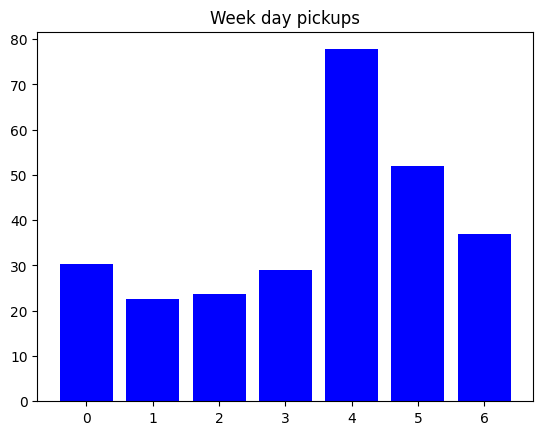

In [102]:
plt.bar(df['pickup_weekday'] , df['tip_amount'], color='blue')
plt.title('Week day pickups')


Text(0.5, 1.0, 'Week day dropoff')

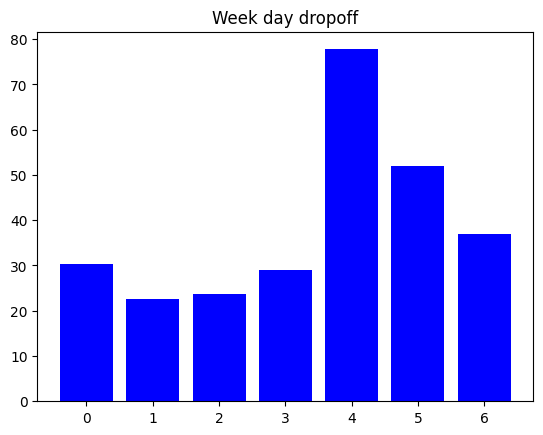

In [103]:
plt.bar(df['dropoff_weekday'] , df['tip_amount'], color='blue')
plt.title('Week day dropoff')

(0.0, 110.0)

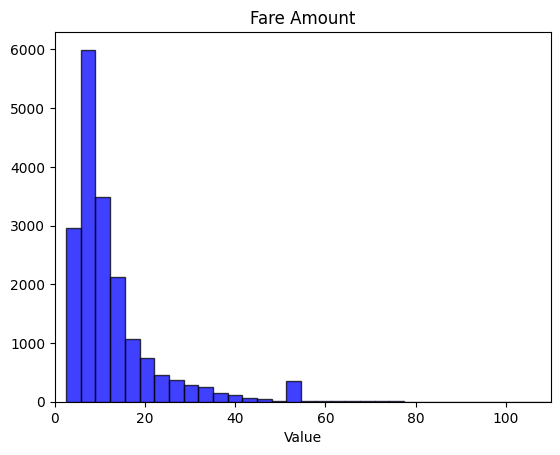

In [17]:
plt.hist(np.array(df['fare_amount']) , bins=64, edgecolor='black' ,facecolor='blue', alpha=0.75)
plt.xlabel('Value')
plt.title('Fare Amount')
plt.xlim(0,110)

(0.0, 20.0)

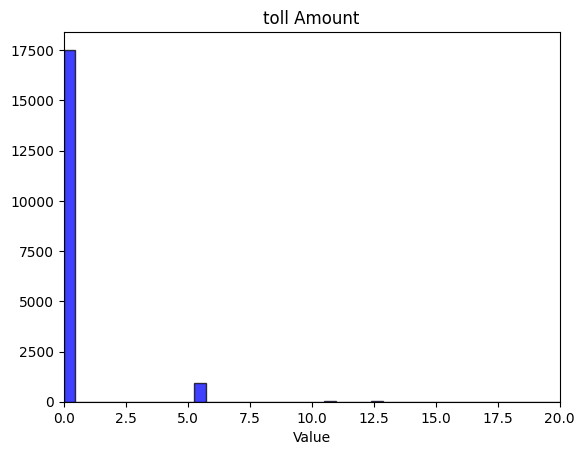

In [20]:
plt.hist(np.array(df['tolls_amount']) , bins=64, edgecolor='black' ,facecolor='blue', alpha=0.75)
plt.xlabel('Value')
plt.title('toll Amount')
plt.xlim(0,20)

In [155]:
fig = px.scatter(df, 'tip_amount', 'fare_amount', color= 'pickup_weekday',  template="simple_white" , title="Tip amount vs Fare Amount")
fig.show()

In [157]:
fig = px.scatter(df, 'tip_amount', 'trip_duration', color= 'pickup_weekday',  template="simple_white", title="Tip amount vs Trip Duration" )
fig.show()

In [167]:
fig = px.scatter(df, 'tip_amount', 'trip_distance', color= 'pickup_weekday',  template="simple_white" , title="Tip amount vs distance")
fig.show()

As depicted in the figure , we see that passengers tip differently based on the day of the week. This leads us to look into the time of the day the trip was mad. We also see that depending of the time of the day, passengers generally have different tipping behaviors as illustrated in figure

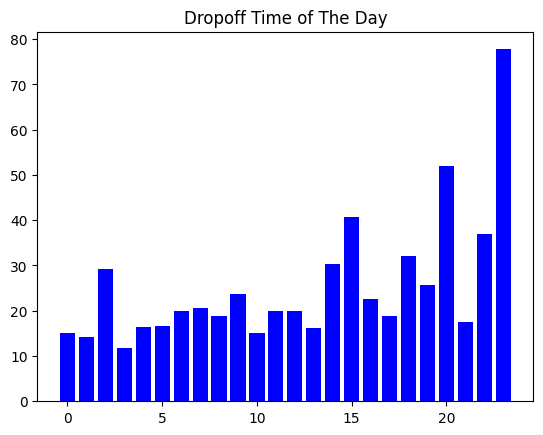

In [145]:
plt.bar(df['dropoff_hour'] , df['tip_amount'], color='blue')
plt.title('Dropoff Time of The Day')
plt.show()

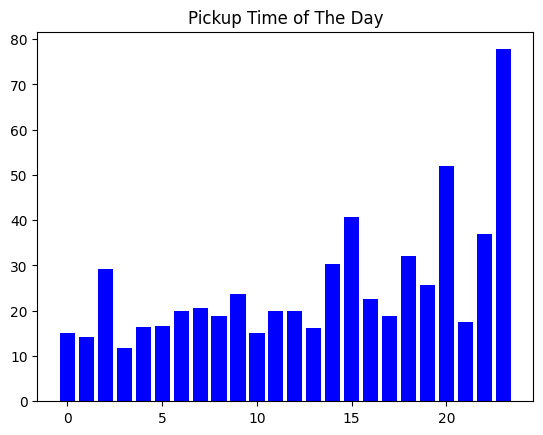

In [146]:
plt.bar(df['pickup_hour'] , df['tip_amount'], color='blue')
plt.title('Pickup Time of The Day')
plt.show()

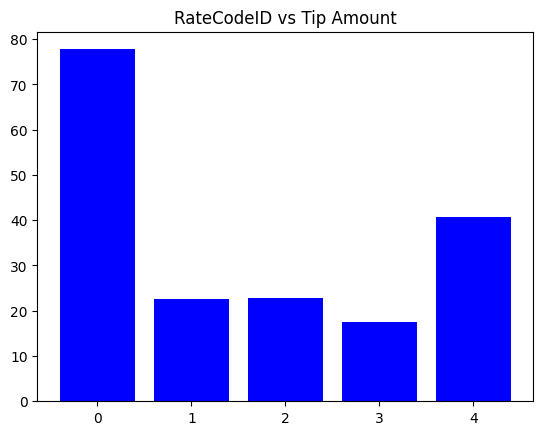

In [151]:
plt.bar(df['RatecodeID'] , df['tip_amount'], color='blue')
plt.title('RateCodeID vs Tip Amount')
plt.show()

We can see a trend here that passengers tend to tip lower in the early hours of the day, 3am to 6am. However, the tip increases as the day goes by, notice a higher average tip in the afternoon from 1400hrs to 1800hrs and we see the highest tips from 1900hrs to 2300hr.
Now I proceed to look at the RateCodeID in correlation with the tip amount. The RateCodeID tells us the trip destination and as we saw from figure 2, drop-offs are more widely dispersed throughout the outlying boroughs while pickups are predominantly focused on Manhattan, LaGuardia, and JFK. Now to explore if these different destinations affect the tip amount, we
Page 10 of 18
look at figure 5. Observe that tip amount is higher with standard rides followed but negotiated rides.

## Correlation between different features:

Correlation is the way of understanding the strength of the relationship between 2 variables or features in a dataset. Correlation coefficients determine this strength by indicating a value between [-1,1] where -1 indicates a very strong negative relationship, 0 indicates no relationship and 1 indicates strong positive relationship. Pearson correlation is one of the most widely used correlation method and it indicates the linear relationship between 2 variables. Figure 9 shows us the correlation between all the variables in the data set.

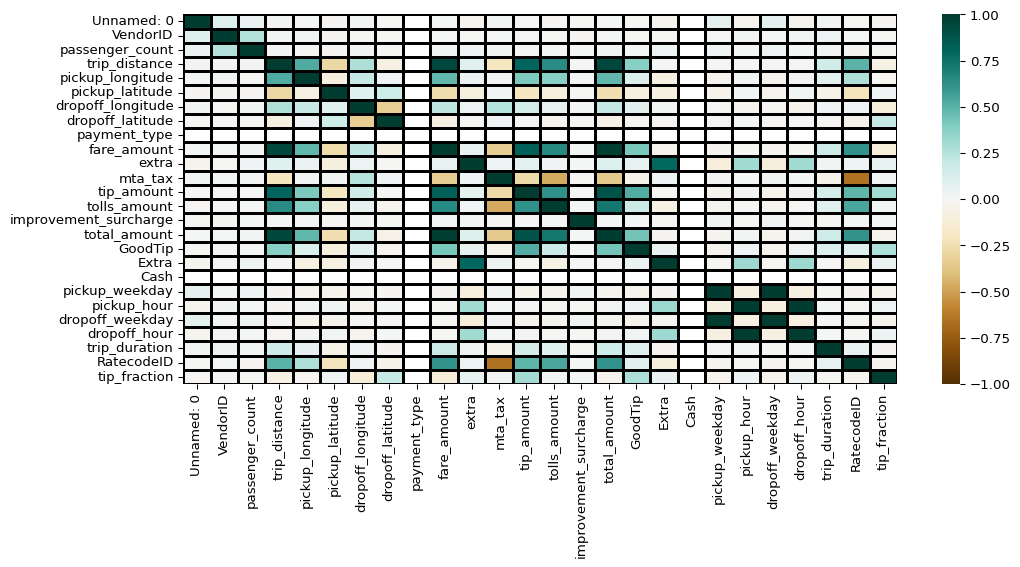

In [159]:

plt.figure(figsize = (12, 5), dpi = 96)
sns.heatmap(df.corr(), annot_kws={"size": 10}, linewidth=1, linecolor="black", cmap='BrBG', vmin=-1, vmax=1)
plt.show()

Figure 10 shows us the correlation between tip amount and the rest of the variables. From this correlation and our visualization, I can now select variables that are highly correlated to tip amount and use them to do some statistical analysis (Model building).

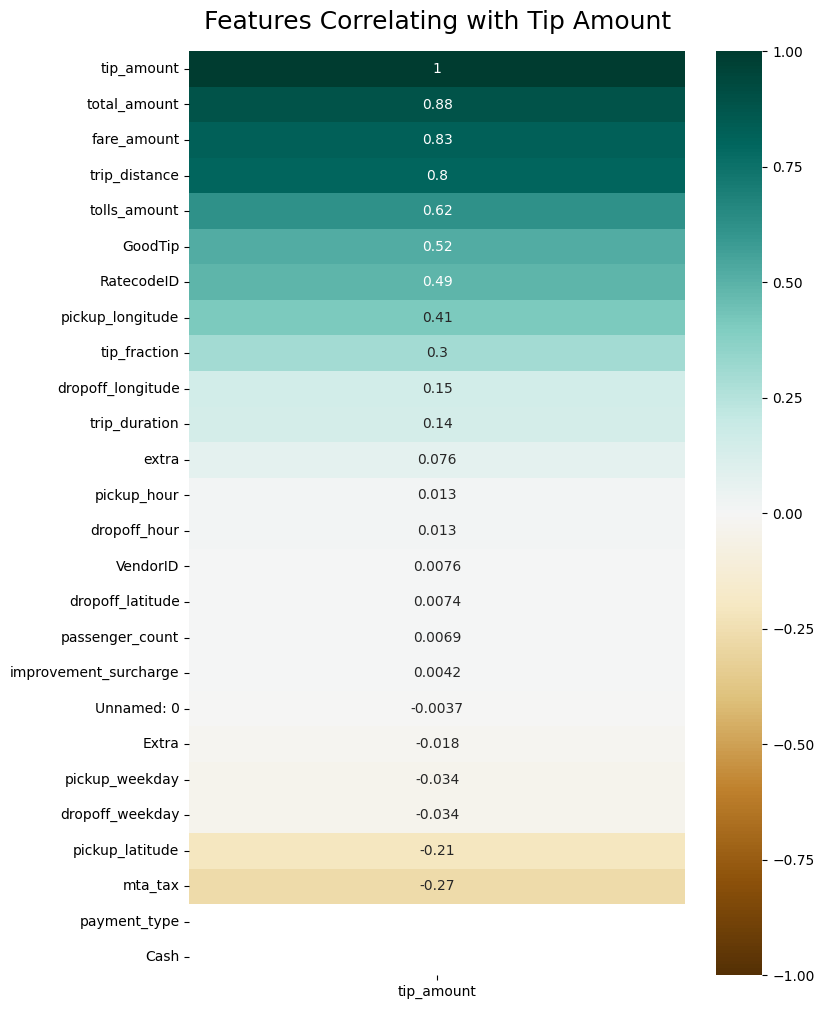

In [160]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['tip_amount']].sort_values(by='tip_amount', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Tip Amount', fontdict={'fontsize':18}, pad=16);

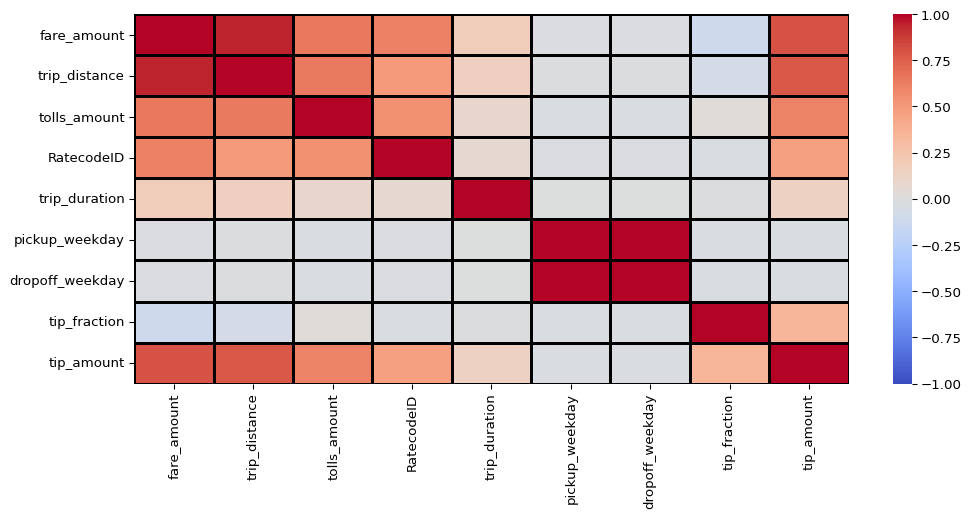

In [168]:
plt.figure(figsize = (12, 5), dpi = 96)
sns.heatmap(df_new.corr(), annot_kws={"size": 10}, linewidth=1, linecolor="black", cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

From my correlation and visualization, I have selected the following variables for building my models as the show correlation to the tip amount :
Fare_amount
Trip_distance
Tolls_amount
RateCodeID
Trip_duration
Pickup_weekday and
Page 14 of 18
Dropoff_Weekday

In [132]:
df_new = df.loc[:,['fare_amount', 'trip_distance', 'tolls_amount', 'RatecodeID', 'trip_duration', 'pickup_weekday', 'dropoff_weekday', 'tip_fraction',
 'tip_amount']]

df_new.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18542 entries, 1 to 28453
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fare_amount      18542 non-null  float64
 1   trip_distance    18542 non-null  float64
 2   tolls_amount     18542 non-null  float64
 3   RatecodeID       18542 non-null  int64  
 4   trip_duration    18542 non-null  float64
 5   pickup_weekday   18542 non-null  int64  
 6   dropoff_weekday  18542 non-null  int64  
 7   tip_fraction     18542 non-null  float64
 8   tip_amount       18542 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 1.4 MB


## Data Anlysis

In this section, we will build four different models to predict the tip amount in taxi trips in New York City. Model fit is evaluated using the train-test split method to randomly split sampled data into 80% training set and 20% testing set. Before splitting, I have one more preprocess to do, I have some categorical variable in my selected variables which I need to dummify in other to fit a logistic regression.

In [133]:
# df_new = df_new[df_new['tip_amount'].notnull()]
print(df_new.isnull().sum())
df_new.describe()

fare_amount        0
trip_distance      0
tolls_amount       0
RatecodeID         0
trip_duration      0
pickup_weekday     0
dropoff_weekday    0
tip_fraction       0
tip_amount         0
dtype: int64


fare_amount  trip_distance  tolls_amount    RatecodeID  trip_duration  \
count  18542.000000   18542.000000  18542.000000  18542.000000   18542.000000   
mean      12.754727       3.001266      0.337204      0.031011      15.270662   
std       10.550342       3.599790      1.525523      0.239686      49.822281   
min        2.500000       0.050000      0.000000      0.000000       0.016667   
25%        6.500000       1.050000      0.000000      0.000000       6.766667   
50%        9.500000       1.750000      0.000000      0.000000      11.066667   
75%       14.500000       3.200000      0.000000      0.000000      17.450000   
max      211.000000      55.900000     30.540000      4.000000    1439.166667   

       pickup_weekday  dropoff_weekday  tip_fraction    tip_amount  
count    18542.000000     18542.000000  18542.000000  18542.000000  
mean         3.014777         3.014777      0.214999      2.628327  
std          1.985221         1.985221      0.100058      2.500856  
min          0.000000         0.000000      0.000000      0.000000  
25%          1.000000         1.000000      0.187500      1.350000  
50%          3.000000         3.000000      0.221333      2.000000  
75%          5.000000         5.000000      0.246852      3.000000  
max          6.000000         6.000000      4.800000     77.770000

### Dummy Variables

A dummy variable is a binary variable that takes a value of 0 or 1. One adds such variables to a regression model to represent factors which are of a binary nature i.e. they are either observed or not observed3. In this case we dummify variables like weekdays and RateCodeID.
This can be seen in figure 10.

In [134]:
categorical_cols = ['RatecodeID','dropoff_weekday', 'pickup_weekday']

#import pandas as pd
df_dummies= pd.get_dummies(df_new, columns = categorical_cols)
df_dummies

fare_amount  trip_distance  tolls_amount  trip_duration  tip_fraction  \
1             14.0           3.90           0.0      12.750000      0.217857   
2              7.0           1.25           0.0       6.933333      0.237143   
3              7.5           0.96           0.0      10.100000      0.234667   
9             15.0           3.90           0.0      15.750000      0.323333   
11             7.5           1.80           0.0       5.750000      0.666667   
...            ...            ...           ...            ...           ...   
28443          5.5           1.07           0.0       4.116667      0.218182   
28445         11.5           3.15           0.0      10.700000      0.000000   
28447          6.0           0.92           0.0       5.466667      0.166667   
28449          7.0           1.68           0.0       5.300000      0.237143   
28453          5.5           0.82           0.0       5.100000      0.181818   

       tip_amount  RatecodeID_0  RatecodeID_1  RatecodeID_2  RatecodeID_3  \
1            3.05             1             0             0             0   
2            1.66             1             0             0             0   
3            1.76             1             0             0             0   
9            4.85             1             0             0             0   
11           5.00             1             0             0             0   
...           ...           ...           ...           ...           ...   
28443        1.20             1             0             0             0   
28445        0.00             1             0             0             0   
28447        1.00             1             0             0             0   
28449        1.66             1             0             0             0   
28453        1.00             1             0             0             0   

       ...  dropoff_weekday_4  dropoff_weekday_5  dropoff_weekday_6  \
1      ...                  1                  0                  0   
2      ...                  1                  0                  0   
3      ...                  1                  0                  0   
9      ...                  1                  0                  0   
11     ...                  1                  0                  0   
...    ...                ...                ...                ...   
28443  ...                  0                  0                  1   
28445  ...                  0                  0                  1   
28447  ...                  0                  0                  1   
28449  ...                  0                  0                  1   
28453  ...                  0                  0                  1   

       pickup_weekday_0  pickup_weekday_1  pickup_weekday_2  pickup_weekday_3  \
1                     0                 0                 0                 0   
2                     0                 0                 0                 0   
3                     0                 0                 0                 0   
9                     0                 0                 0                 0   
11                    0                 0                 0                 0   
...                 ...               ...               ...               ...   
28443                 0                 0                 0                 0   
28445                 0                 0                 0                 0   
28447                 0                 0                 0                 0   
28449                 0                 0                 0                 0   
28453                 0                 0                 0                 0   

       pickup_weekday_4  pickup_weekday_5  pickup_weekday_6  
1                     1                 0                 0  
2                     1                 0                 0  
3                     1                 0                 0  
9                     1                 0      

In [ ]:

#Dummies for categorial variable
# features = ['fare_amount', 'trip_distance', 'tolls_amount', 'RatecodeID', 'trip_duration', 
#  'dropoff_weekday', 'pickup_weekday', 'dropoff_hour', 'pickup_hour']

# for variable in features:
#     dummies = pd.get_dummies(df_new[features], prefix=variable)
#     df_01 = pd.concat([df_new, dummies], axis =1)
#     df_01.drop([variable], axis= 1, inplace=True)

# df_01.columns

# features.remove('tip_amount')

# X = df_dummies[features]
# Y = df_dummies['tip_amount']
# features = list(df_dummies.columns.values[1:-1])


### Train Test Split

The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model. And the most recommended ration is 80:20 train test split which is what I used. So I remove my target variable, and split the data into four portions, dependent and independent sets of train and test.

In [135]:
# Train test split
tip_amount = df_dummies['tip_amount']
df_new1 = df_dummies.drop(['tip_amount'], axis=1)



xtrain, xtest, ytrain, ytest= train_test_split(df_new1, tip_amount, test_size=0.2, random_state=42)
ytrain_reshaped = ytrain.values.reshape(-1, 1)
ytest_reshaped = ytest.values.reshape(-1, 1)

### Models

Model building is the use of statistical tools to create mathematical representations by generalizing and learning from training data. I build four different regression models and used the root mean square error, rmse as my determinant fact for model evaluation. Root Mean Square Error, rmse is the measure of how well a regression line fits the data points.
The three models I will be using are:
•	Logistic Regression
•	Decision Tree
•	Random Forest
•	Gradient Boosting Regression
The results of my models are compared below:


In [162]:
#Regresssion model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
Lmodel = LinearRegression()
Lmodel.fit(xtrain , ytrain_reshaped)
ypred = Lmodel.predict(xtest)
ypred.shape
Lmodel.score(xtest, ytest_reshaped)

rsme_Lmodel = np.sqrt(mean_squared_error(ytest_reshaped, ypred))

print(f"\n\nLinear Regression\n{'-' * 50}")
print(f"R-squared: {r2_score(ytest_reshaped, ypred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(ytest_reshaped, ypred):.3f}")
print(f"Root Mean Squared Error: {rsme_Lmodel:.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(ytest_reshaped, ypred):.3f}")



Linear Regression
--------------------------------------------------
R-squared: 0.808
Mean Squared Error: 1.498
Root Mean Squared Error: 1.224
Mean Absolute Error: 0.388


In [163]:
#decision tree
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor() 
dtree.fit(xtrain, ytrain)
ypred = dtree.predict(xtest)
dtree.score(xtest, ytest)
rmse_dtree = np.sqrt(mean_squared_error(ytest_reshaped, ypred))

print(f"\n\nDecision Tree\n{'-' * 50}")
print(f"R-squared: {r2_score(ytest_reshaped, ypred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(ytest_reshaped, ypred):.3f}")
print(f"Root Mean Squared Error: {rmse_dtree:.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(ytest_reshaped, ypred):.3f}")



Decision Tree
--------------------------------------------------
R-squared: 0.862
Mean Squared Error: 1.078
Root Mean Squared Error: 1.038
Mean Absolute Error: 0.047


In [166]:
from sklearn. ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor( )
GBR.fit(xtrain, ytrain)
ypred = GBR.predict(xtest)
rsme_GBR = np.sqrt(mean_squared_error(ytest_reshaped, ypred))
GBR.score(xtest, ytest)

# print(f"\n\nTGradient Boosting Regressor\n{'-' * 50}")
# print(f"R-squared: {r2_score(ytest_reshaped, ypred):.3f}")
# print(f"Mean Squared Error: {mean_squared_error(ytest_reshaped, ypred):.3f}")
# print(f"Root Mean Squared Error: {rsme_GBR:.3f}")
# print(f"Mean Absolute Error: {mean_absolute_error(ytest_reshaped, ypred):.3f}")

0.867449939123323

In [165]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit( xtrain, ytrain)
ypred = rf.predict(xtest)
rf.score(xtest, ytest)
rmse_rf = np.sqrt(mean_squared_error(ytest_reshaped, ypred))

print(f"\n\nRandom Forest Regressor\n{'-' * 50}")
print(f"R-squared: {r2_score(ytest_reshaped, ypred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(ytest_reshaped, ypred):.3f}")
print(f"Root Mean Squared Error: {rmse_rf:.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(ytest_reshaped, ypred):.3f}")



Random Forest Regressor
--------------------------------------------------
R-squared: 0.859
Mean Squared Error: 1.102
Root Mean Squared Error: 1.050
Mean Absolute Error: 0.045


## Results and Conclusions

Taking the rmse as my determinant factor, I listed my results to filter just the rmse for the different models and the results is seen in figure

The best model for our dataset is the Gradient Boosting Regressor with the lowest root mean square of 1.0173617031746665. This model has an accuracy score of 86.7%. I applied GridSearch cross validation to the gradient boosting model to optimize hyper parameters as shown in figure 

In [142]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randInt
grid_GBC = GradientBoostingRegressor()
parameters = {'learning_rate': [0.01,0.02,0.03],
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4,6,8]
                 }
grid_GBC = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBC.fit(xtrain, ytrain)
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBC.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBC.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBC.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.03, max_depth=4, n_estimators=1000,
                          subsample=0.5)

 The best score across ALL searched params:
 0.9503660289327409

 The best parameters across ALL searched params:
 {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.5}


In [141]:
# Determine best model
Lin_reg = format(rsme_Lmodel)

gbr = format(rsme_GBR)

random_forest = format(rmse_rf)

decision_tree = format(rmse_dtree)

best_model = pd.DataFrame(
    {'Model' : ['Linear_Regression', 'Gradient Boosting regressor','Random Forest', 'Decision tree'],
    'RMSE': [Lin_reg,gbr,random_forest, decision_tree]
    })

best_model

Model                RMSE
0            Linear_Regression  1.2239295016301701
1  Gradient Boosting regressor  1.0173617031746665
2                Random Forest  1.0656737946635055
3                Decision tree   1.084616654214825